Customer Lifetime Value Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

In [2]:

df = pd.read_csv('/Users/helen/Desktop/Customer_LifeTime_Prediction/customer_segmentation.csv', encoding='ISO-8859-1')

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
df.shape

(541909, 8)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


# Data Exploration and Cleaning

In [5]:
#checking the data types 
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [6]:
#Checking if there is any null values
df.isnull().values.any() 

True

In [7]:
#checks for missing values in columns
df.isna().sum() # 24.9% of the customer id  is missing and a 1454 records of description, 
#the description is inconsequential but a decision has to be made concerning missing customer id

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [8]:
# dropping rows with missing customer_id
df = df[df['CustomerID'].notna()] #CustomerID is important for CLV prediction

df.shape

(406829, 8)

In [9]:
#Changing customer_id to string.. object data type
df['CustomerID'] = df['CustomerID'].round().astype(int)
df['CustomerID'] = df['CustomerID'].astype(str)


#converting invoice date to date time datatype, customer_id from float to string
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors= "coerce")
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID             object
Country                object
dtype: object

In [10]:
#Checking for any NaT values
df['InvoiceDate'].isnull().values.any()  # OR df['InvoiceDate'].isna().sum() > 0


False

In [11]:
#counting number of unique countries
df['Country'].nunique()

37

In [12]:
#checking countries 
df['Country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Saudi Arabia', 'Czech Republic', 'Canada',
       'Unspecified', 'Brazil', 'USA', 'European Community', 'Bahrain',
       'Malta', 'RSA'], dtype=object)

In [13]:
#obtaining records of unspecified countries
df[df['Country'] == 'Unspecified']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
152712,549687,20685,DOORMAT RED RETROSPOT,2,2011-04-11 13:29:00,7.95,12363,Unspecified
152713,549687,22691,DOORMAT WELCOME SUNRISE,2,2011-04-11 13:29:00,7.95,12363,Unspecified
152714,549687,48116,DOORMAT MULTICOLOUR STRIPE,2,2011-04-11 13:29:00,7.95,12363,Unspecified
152715,549687,21213,PACK OF 72 SKULL CAKE CASES,24,2011-04-11 13:29:00,0.55,12363,Unspecified
152716,549687,21977,PACK OF 60 PINK PAISLEY CAKE CASES,24,2011-04-11 13:29:00,0.55,12363,Unspecified
...,...,...,...,...,...,...,...,...
308810,564051,23007,SPACEBOY BABY GIFT SET,1,2011-08-22 13:32:00,16.95,14265,Unspecified
308811,564051,21833,CAMOUFLAGE LED TORCH,12,2011-08-22 13:32:00,1.69,14265,Unspecified
308812,564051,23081,GREEN METAL BOX ARMY SUPPLIES,2,2011-08-22 13:32:00,8.25,14265,Unspecified
308813,564051,23046,PAPER LANTERN 9 POINT DELUXE STAR,2,2011-08-22 13:32:00,6.65,14265,Unspecified


## Handling missing values

In [14]:
#checking for any missing value
df.isnull().values.any()

False

In [15]:
#checking if there exists the same invoice number for different country
unique_group =  df[['InvoiceNo','Country']].drop_duplicates()
duplicates  = unique_group['InvoiceNo'].duplicated().sum()
duplicates

0

In [16]:
#counting the unique countries for each Invoice No
invoice_country_count = df.groupby('InvoiceNo')[['Country', 'InvoiceDate']].nunique()

#finding invoices that are related to more than one country
duplicate_invoice =  invoice_country_count[invoice_country_count['Country']>1]
print(f"Number of Invoice No appearing in multiple countries are: {len(duplicate_invoice)}")

#finding invoices that are related to more than one date
duplicate_invoice =  invoice_country_count[invoice_country_count['InvoiceDate']>1]
print(f"Number of Invoice No appearing in multiple InvoiceDates are: {len(duplicate_invoice)}")

Number of Invoice No appearing in multiple countries are: 0
Number of Invoice No appearing in multiple InvoiceDates are: 31


Observation: Based on the above observation
The invoices are unique to each countries

In [17]:
#checking how many countries that a customer id appears
customer_country_count = df.groupby('CustomerID')['Country'].nunique()
customer_country_duplicates = customer_country_count[customer_country_count>1]
print(f"Most customer order from the same country except : {len(customer_country_duplicates)}")

Most customer order from the same country except : 8


Task: Filling "unspecified country" with most common country because it was observed that all customers with missing countries have their country name missing for all transactions.most commom country is "United Kingdom"

In [18]:
#Filling "unspecified country" with most common country"
customer_country_map = df["Country"].agg(lambda x: x.mode()[0]) #customer_country_map = df["Country"].agg(lambda x: x.mode()[0]if not x.isnull().all() else None)

#Now fill with missing country with the most frequent country for the customers
df['Country'] = df['Country'].replace("Unspecified", np.nan)
df['Country']= df['Country'].fillna(customer_country_map)

In [19]:
df[df['Country']== 'Unspecified'] # confirmed that all unspecified country has been filled

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


In [20]:
#Missing values in columns
df.isna().sum() 

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [21]:
#checking for any duplicated rows
df.duplicated().values.any()

True

In [22]:
#checks for duplicate
df.duplicated(keep= 'first').sum()

5225

In [23]:
df[df.duplicated(keep=False)].head(20)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908,United Kingdom
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908,United Kingdom
548,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,2010-12-01 11:49:00,2.95,17920,United Kingdom
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,2010-12-01 11:49:00,2.95,17920,United Kingdom


Observation: Duplicated transactions are not dropped as they are assumed to be multiple transaction of the same order by the same customer in the same time.

## Checks for outliers

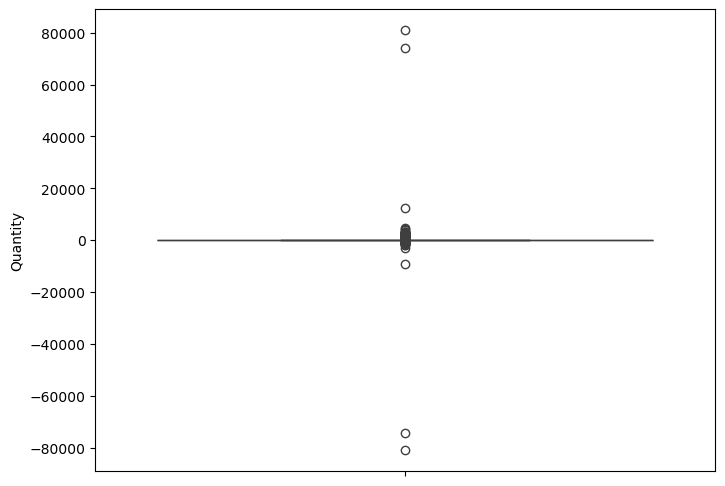

In [24]:
#Visualizing outliers with boxplot for numeric column field Quantity and UnitPrice
plt.figure(figsize = (8,6))


sns.boxplot(df["Quantity"])


plt.show()

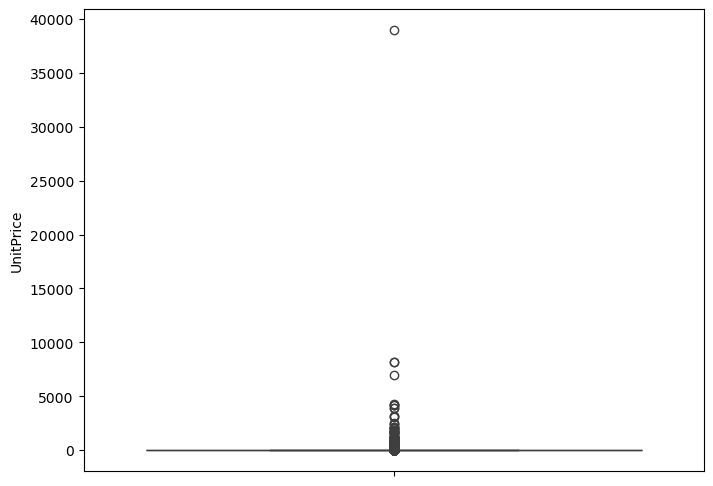

In [25]:
plt.figure(figsize = (8,6))

sns.boxplot(df["UnitPrice"])


plt.show()

In [26]:
#Using zscore to see how far each data point is from the mean for Quantity and Unit Price
from scipy import stats

quantity_z_score = np.abs(stats.zscore(df["Quantity"]))
unitPrice_z_score = np.abs(stats.zscore(df["UnitPrice"]))
print(f"z_score for {"Quantity"} is: {quantity_z_score}")
print(f"z_score for {"UnitPrice"} is: {unitPrice_z_score}")


z_score for Quantity is: [0.02437263 0.02437263 0.01633059 ... 0.03241467 0.03241467 0.03643569]
z_score for UnitPrice is: [0.01313525 0.00101668 0.01024988 ... 0.00994775 0.00994775 0.02148925]


In [27]:
#Removal of outliers, using a threshold 3, where zvalue is greater than 3
z_threshold = 3

quantity_outliers = np.where((quantity_z_score > z_threshold) | (quantity_z_score < -z_threshold))[0]
unitPrice_outliers = np.where((unitPrice_z_score > z_threshold) | (unitPrice_z_score < -z_threshold))[0]

outlier_indices = np.union1d(quantity_outliers, unitPrice_outliers)

no_outliers_df =  df.drop(index = df.index[outlier_indices])
print("Original dataframe shape: ", df.shape)
print("Dataframe after removing outliers", no_outliers_df.shape)

Original dataframe shape:  (406829, 8)
Dataframe after removing outliers (406492, 8)


In [28]:
#Assigning no_outliers_df as the dataframe to work with 
df = no_outliers_df
df.shape

(406492, 8)

In [29]:
#Checking for negative quantity value

df[df["Quantity"]< 0].head(25)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2010-12-01 10:24:00,3.45,17548,United Kingdom
240,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,2010-12-01 10:24:00,1.65,17548,United Kingdom
939,C536506,22960,JAM MAKING SET WITH JARS,-6,2010-12-01 12:38:00,4.25,17897,United Kingdom


In [30]:
#shape of data setafter dropping negative quantities
df.shape

(406492, 8)

Assumption:
Dropping rows with negative quantity with the assumption they are returned items

In [31]:
#dropping rows with negative quantity with the assumption they are returned items
df = df[df["Quantity"]>0]
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


# Descriptive Statistics and Exploratory Data Analysis (EDA)

Assumption:
assumptions  were  made that  duplicated transactions with all columns the same were transactions of products made twice at the same time by same customers, and leaving them as they are.

In [32]:
df.describe(include='number')

,Quantity,UnitPrice
count,397679.000000,397679.000000
mean,12.029064,2.930690
std,29.664228,4.106585
min,1.000000,0.000000
25%,2.000000,1.250000
50%,6.000000,1.950000
75%,12.000000,3.750000
max,756.000000,208.340000


In [33]:
df.describe(include='object')

,InvoiceNo,StockCode,Description,CustomerID,Country
count,397679,397679,397679,397679,397679
unique,18440,3663,3874,4326,36
top,576339,85123A,WHITE HANGING HEART T-LIGHT HOLDER,17841,United Kingdom
freq,541,2031,2024,7847,354393


In [34]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [35]:
df['CustomerID'].nunique()

4326

In [36]:
#obtaining distribution of customers across countries
cust_perCountry = df.groupby('Country')['CustomerID'].nunique().reset_index(name='Count')
cust_perCountry['percentage'] = round(cust_perCountry['Count']/cust_perCountry['Count'].sum() *100, 2)
cust_perCountry.sort_values(by='percentage', ascending=False).reset_index(drop=True).set_axis(range(1, len(cust_perCountry)+1))

,Country,Count,percentage
1,United Kingdom,3912,90.26
2,Germany,94,2.17
3,France,87,2.01
4,Spain,30,0.69
5,Belgium,25,0.58
6,Switzerland,21,0.48
7,Portugal,19,0.44
8,Italy,14,0.32
9,Finland,12,0.28
10,Austria,11,0.25


In [37]:
#obtaining top 10 values
top10_cust_perCountry = cust_perCountry.sort_values(by='percentage', ascending=False).reset_index(drop=True).head(10)
top10_cust_perCountry

,Country,Count,percentage
0,United Kingdom,3912,90.26
1,Germany,94,2.17
2,France,87,2.01
3,Spain,30,0.69
4,Belgium,25,0.58
5,Switzerland,21,0.48
6,Portugal,19,0.44
7,Italy,14,0.32
8,Finland,12,0.28
9,Austria,11,0.25


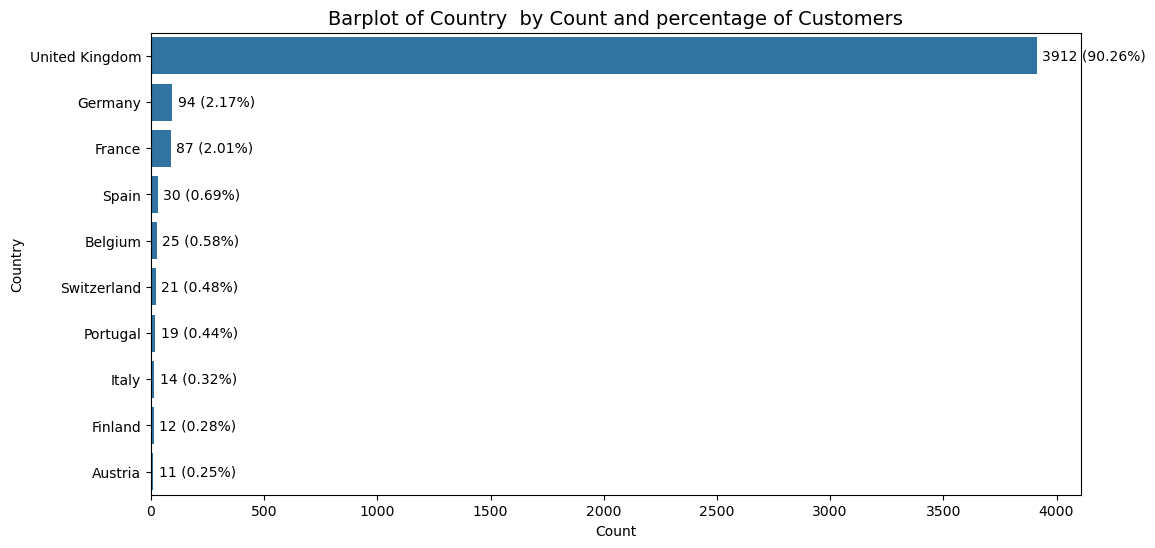

In [38]:
#plot of "Barplot of Country  against Count and percentage of Customers"

plt.figure(figsize=(12,6))
ax = sns.barplot(top10_cust_perCountry, x = 'Count', y= 'Country')

ax.set_title("Barplot of Country  by Count and percentage of Customers", fontsize =14)

labels = [f"{count} ({percent}%)" for count, percent in zip(top10_cust_perCountry['Count'], top10_cust_perCountry['percentage'])]

ax.bar_label(ax.containers[0], labels= labels, fontsize=10, padding =4)

plt.show()

In [39]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [40]:
# Checks to see relationship between stockcodes and description 
print("the no of unique stock codes are: ", df['StockCode'].nunique())
print("the no of unique descriptions are: ", df['Description'].nunique())

#obtaining unique pairs
unique_pairs = df[['StockCode','Description']].drop_duplicates()
unique_pairs

duplicate_count = unique_pairs['StockCode'].duplicated().sum()
if duplicate_count ==0:
    print("Each stockcode has a unique 'descriptions'" "(One-to-One relationship)")
else:
    print(f"{duplicate_count} 'stockcodes' has multple descriptions ")


the no of unique stock codes are:  3663
the no of unique descriptions are:  3874
231 'stockcodes' has multple descriptions 


In [41]:
#Dropping description column as it is not instrumental to our analysis
df = df.drop(columns='Description')
df.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [42]:
top10_stocks_byFreq = df['StockCode'].value_counts()\
                                    .reset_index(name='Frequency')\
                                    .sort_values(by ='Frequency', ascending=False).head(10)
top10_stocks_byFreq

,StockCode,Frequency
0,85123A,2031
1,22423,1724
2,85099B,1615
3,84879,1405
4,47566,1397
5,20725,1317
6,22720,1159
7,20727,1105
8,23203,1098
9,POST,1091


In [43]:
top10_stocks_byFreq['Frequency'].mean()

1394.2

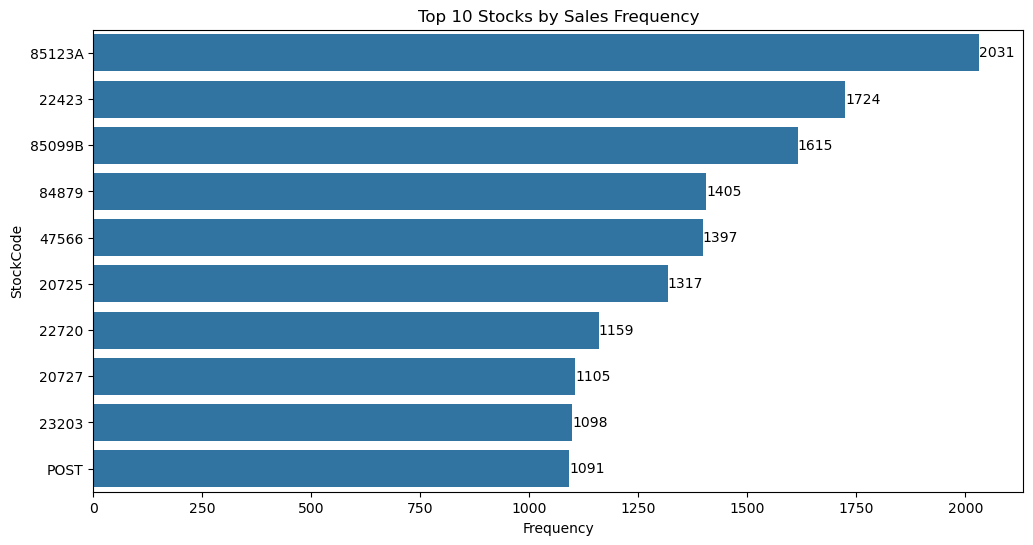

In [44]:
#Obtaining top 10 sales frequency using stockcode as unique identifier of products

plt.figure(figsize=(12,6))

ax =sns.barplot(top10_stocks_byFreq, y = "StockCode", x= "Frequency")
ax.bar_label(ax.containers[0], labels = top10_stocks_byFreq["Frequency"], fontsize =10)
ax.set_title("Top 10 Stocks by Sales Frequency")

plt.show()

In [45]:
df.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


#group by customer and transaction volume.
#group by customer and quantity of purchase
#group by monetary value and quarterly from 2010 to 2011

In [46]:
#creating new columns to depict Total Sales 
df['TotalSales'] = df['UnitPrice'].mul(df['Quantity'])


In [47]:
df.dtypes

InvoiceNo              object
StockCode              object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID             object
Country                object
TotalSales            float64
dtype: object

In [48]:
#Group by customer and transaction volume including Guests (customers with unknown id)
cust_ByTrans = df.groupby("CustomerID")['TotalSales'].sum().reset_index(name="TotalRevenue")
cust_ByTrans

,CustomerID,TotalRevenue
0,12347,4310.00
1,12348,1797.24
2,12349,1457.55
3,12350,334.40
4,12352,1849.49
...,...,...
4321,18280,180.60
4322,18281,80.82
4323,18282,178.05
4324,18283,2094.88


In [49]:
cust_ByTrans= cust_ByTrans.sort_values(by = "TotalRevenue", ascending=False).head(20)
cust_ByTrans

,CustomerID,TotalRevenue
1686,14646,268891.46
4190,18102,250509.70
3719,17450,152206.35
1876,14911,140450.72
54,12415,122212.53
1330,14156,116746.03
3762,17511,91062.38
3169,16684,66381.56
993,13694,64640.74
2696,16029,62148.81


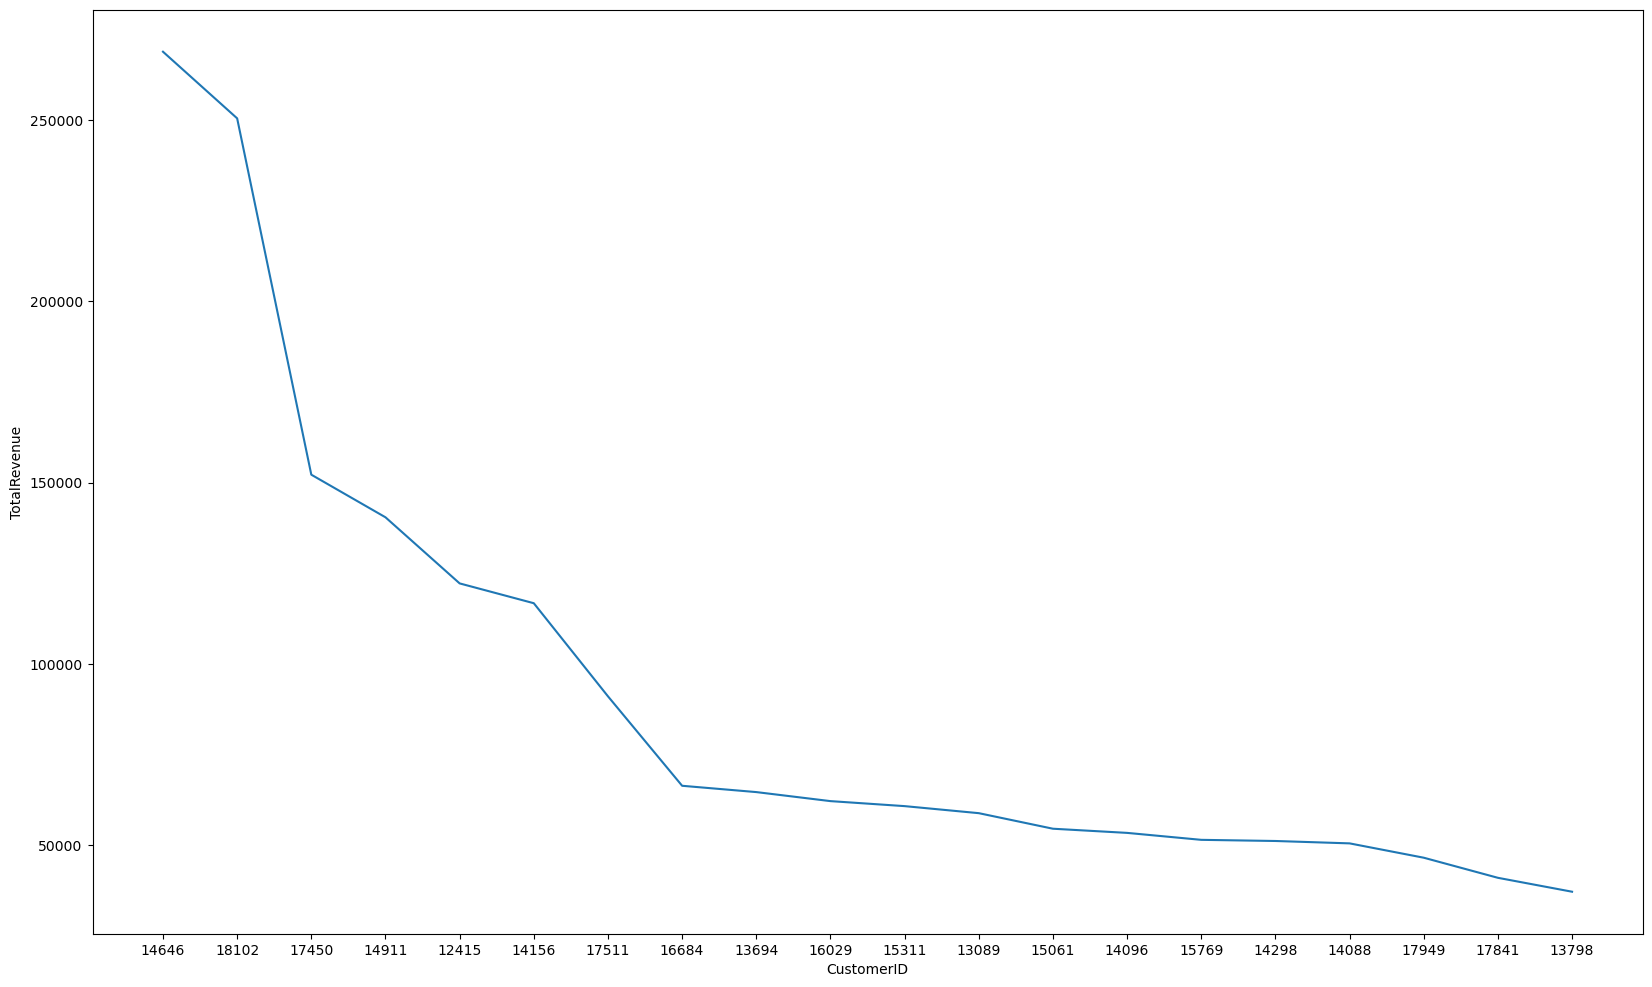

In [50]:
#obtaining the top 20 highest revenue generating customers
plt.figure(figsize=(20, 12))
sns.lineplot(data =cust_ByTrans, x="CustomerID" , y = "TotalRevenue")
plt.show()

In [51]:
#Obtaining frequency of purchase by customers quarterly

df['YearQuarter'] =  df["InvoiceDate"].dt.to_period('Q')

Purchase_quarter = df.groupby(["CustomerID", "YearQuarter"]).size().reset_index(name = "Purchase_Count_PerQ")
Purchase_quarter

,CustomerID,YearQuarter,Purchase_Count_PerQ
0,12347,2010Q4,31
1,12347,2011Q1,29
2,12347,2011Q2,42
3,12347,2011Q3,22
4,12347,2011Q4,58
...,...,...,...
9340,18283,2011Q2,211
9341,18283,2011Q3,104
9342,18283,2011Q4,309
9343,18287,2011Q2,29


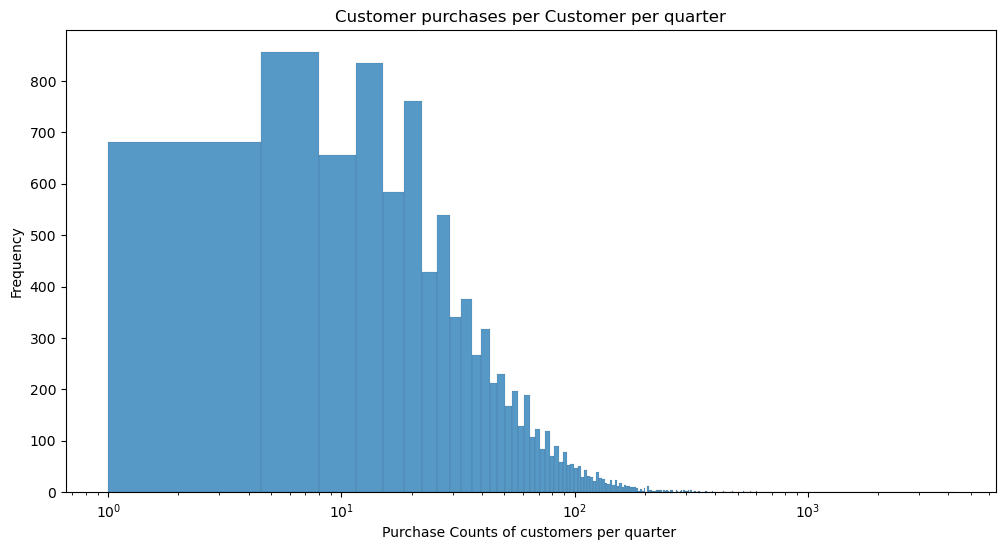

In [52]:
#obtaining distribution of frequency of purchase by customers quarterly
plt.figure(figsize= (12, 6))

sns.histplot(Purchase_quarter["Purchase_Count_PerQ"])#, bins = "auto" , kde=True)
plt.title("Customer purchases per Customer per quarter")
plt.xlabel("Purchase Counts of customers per quarter ")
plt.xscale('log')
plt.ylabel("Frequency")
plt.show()


In [53]:
#obtaining seasonal trend per quarter 
freq_trend  = Purchase_quarter.groupby("YearQuarter")['Purchase_Count_PerQ'].sum().reset_index()
freq_trend

,YearQuarter,Purchase_Count_PerQ
0,2010Q4,26143
1,2011Q1,68290
2,2011Q2,78089
3,2011Q3,93827
4,2011Q4,131330


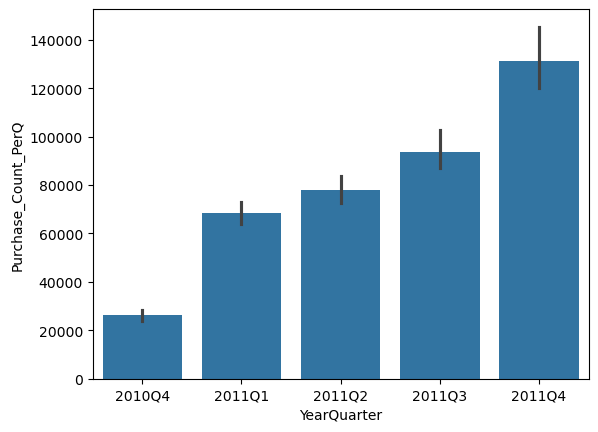

In [54]:
#Highlighting total purchase per quarter.
sns.barplot(x="YearQuarter", y = "Purchase_Count_PerQ", data =Purchase_quarter, estimator=sum)
plt.show()

Observation:
Purcahse frequency increased from 2010 Quarter 4 to 2011 Quarter 4.

In [55]:
df.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSales,YearQuarter
0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010Q4
1,536365,71053,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010Q4
2,536365,84406B,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010Q4
3,536365,84029G,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010Q4
4,536365,84029E,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010Q4


In [56]:
Transaction_df =  df[["YearQuarter", "TotalSales"]]
Transaction_df

,YearQuarter,TotalSales
0,2010Q4,15.30
1,2010Q4,20.34
2,2010Q4,22.00
3,2010Q4,20.34
4,2010Q4,20.34
...,...,...
541904,2011Q4,10.20
541905,2011Q4,12.60
541906,2011Q4,16.60
541907,2011Q4,16.60


In [57]:
#Table sum of sales of finanacial transactions quarterly over the 2 years 2010-2011
Transaction_freq =  df.groupby("YearQuarter")["TotalSales"].sum().reset_index()
Transaction_freq

,YearQuarter,TotalSales
0,2010Q4,551601.430
1,2011Q1,1478047.990
2,2011Q2,1702161.191
3,2011Q3,2149609.003
4,2011Q4,2452268.810


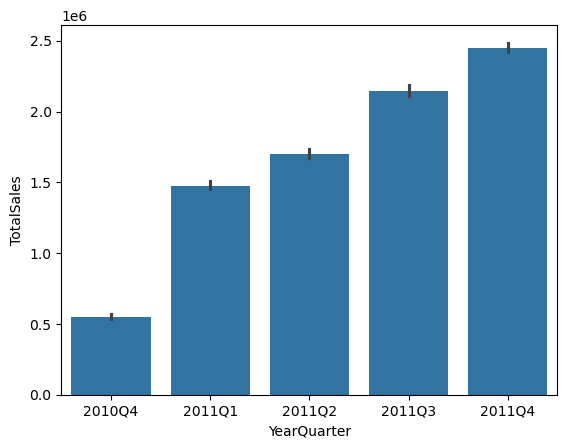

In [58]:
#obtaining distribution of finanacial transactions quarterly over the 2 years 2010-2011
sns.barplot(data = Transaction_df, x= "YearQuarter", y= "TotalSales", estimator=sum)
plt.show()

# Feature Engineering

Removing cut-off date to use the whole dataset as cut-off date with the last 6 month revenue as the target variable 

Obtaining the following values: 

* Recency: How long it's been since a customer's last purchase from the cut-off date. if recency is high, it means customer has not interacted with brand or company in a long while from the cut-off date.
* Frequency: How many times a customer has purchased within a specific given time frame. Given period use in the data set is between overall first date of purchase to the cut-off date.  
* Monetary: How much a customer has spent on a product or service within the same specific given time frame. Given period use in the data set is between overall first date of purchase to the cut-off date.  

In [59]:
df.head(2)

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSales,YearQuarter
0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010Q4
1,536365,71053,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010Q4


In [60]:
#setting a cut-off date to use as 2011-06-30 00:00:00 30th of June, 2011  as cut-off date
# Now recency is  how long its been a customer's last purchase from the cut-off date 


cut_off_date =  pd.to_datetime('2011-06-30 00:00:00')  # As date before the last months 
last_date =  cut_off_date
first_date = pd.to_datetime('2011-03-01 00:00:00') # As the first date of the training set window
print(f"The {first_date} is the first date of purchase")
print(f"The {last_date} is the last cut-off date of purchase")

The 2011-03-01 00:00:00 is the first date of purchase
The 2011-06-30 00:00:00 is the last cut-off date of purchase


In [61]:
df['InvoiceDate'].min()

Timestamp('2010-12-01 08:26:00')

In [62]:
df['YearQuarter'].unique() 

<PeriodArray>
['2010Q4', '2011Q1', '2011Q2', '2011Q3', '2011Q4']
Length: 5, dtype: period[Q-DEC]

Observation: Based on the above, first date of purchase is 1st of March, 2011, and last date of purchase is 9th December, 2011. 
We start our dataset from the first of march 2011, instead of from december because of our assumption 
Assumption made: Customers are  new from the first months, and data records are for existing customers from the 4th month march.

Obtaining our data set for training  and testing set

In [63]:
# Obtaining data from before the cut_off_date
full_df = df[(df['InvoiceDate']<= cut_off_date) & (df['InvoiceDate'] >= first_date)] # slicing dataframe to obtain data before the cut-off date and our first date 
full_df['YearQuarter'].unique() # we obtain data from after our chosen first date and our last date

<PeriodArray>
['2011Q1', '2011Q2']
Length: 2, dtype: period[Q-DEC]

In [64]:
full_df.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSales,YearQuarter
105335,545220,21955,2,2011-03-01 08:30:00,7.95,14620,United Kingdom,15.90,2011Q1
105336,545220,48194,2,2011-03-01 08:30:00,7.95,14620,United Kingdom,15.90,2011Q1
105337,545220,22556,12,2011-03-01 08:30:00,1.65,14620,United Kingdom,19.80,2011Q1
105338,545220,22139,3,2011-03-01 08:30:00,4.95,14620,United Kingdom,14.85,2011Q1
105339,545220,84029G,4,2011-03-01 08:30:00,3.75,14620,United Kingdom,15.00,2011Q1


In [65]:
# Function to obtain Obtaining Recency, Frequency and Monetary values


def create_rfm_values(df_name, date):
    
    #Obtaining latest purchase date for customers before last date in training set. 
    LatestPurchaseDate_df = df_name.groupby("CustomerID")['InvoiceDate'].max().reset_index(name = "LatestPurchaseDate") 
    LatestPurchaseDate_df["Recency"] = date - LatestPurchaseDate_df["LatestPurchaseDate"]

    #converting to days equivalence
    LatestPurchaseDate_df["Recency"] =  LatestPurchaseDate_df["Recency"].dt.days #converting to days equivalence

    # dropping LatestPurchaseDate as it is not currently necessary
    LatestPurchaseDate_df.drop("LatestPurchaseDate", axis =1, inplace=True)

    #Obtaining  Frequency and Monetary value before cut-off Date
    Monetary_val = df_name.groupby("CustomerID")['TotalSales'].sum().reset_index(name = "Monetary") # Obtaining monetary revenue by adding sum of total sales in customers lifetime period

    Frequency_val  =  df_name.groupby("CustomerID")["InvoiceDate"].count().reset_index(name = "Frequency") # grouped independent of date, meaning there could have been 2 purchases in the same day and all will be counted 

    segment_df = pd.merge(pd.merge(LatestPurchaseDate_df, Frequency_val, on= "CustomerID", how = "outer"), Monetary_val, on = "CustomerID", how = "outer")
    return segment_df




In [66]:
#calling the create RFM function

segment_full_df = create_rfm_values(full_df, last_date) 
segment_full_df #this is the data set that has the rfm valus for the  whole dataset from 1st march 2011 to 9th Dec 2011

,CustomerID,Recency,Frequency,Monetary
0,12347,20,42,1018.77
1,12348,85,5,367.00
2,12352,99,21,608.76
3,12353,41,4,89.00
4,12354,69,58,1079.40
...,...,...,...,...
2325,18273,94,1,51.00
2326,18280,114,10,180.60
2327,18281,17,7,80.82
2328,18283,6,211,524.68


Obtaining this data structure :
CustomerID: Unique identifier for each customer. *

Recency: Number of days since the customer's last purchase.*

Frequency: Total number of purchases made by the customer. *

Monetary: Total revenue generated by the customer. *

RecencyCluster, FrequencyCluster, RevenueCluster: Cluster assignments based on Recency, Frequency, and Revenue, respectively. 

OverallScore: Combined RFM score. 

LTVCluster: Target variable representing the LTV cluster.

In [67]:

from sklearn.cluster import KMeans
sse = {}

def optimal_cluster_no(data):
    for k in range(1,10):
        kmeans =    KMeans(n_clusters=k, random_state=0, n_init="auto")
        kmeans.fit(data)
        sse[k] = kmeans.inertia_

In [68]:
segment_full_df

,CustomerID,Recency,Frequency,Monetary
0,12347,20,42,1018.77
1,12348,85,5,367.00
2,12352,99,21,608.76
3,12353,41,4,89.00
4,12354,69,58,1079.40
...,...,...,...,...
2325,18273,94,1,51.00
2326,18280,114,10,180.60
2327,18281,17,7,80.82
2328,18283,6,211,524.68


In [69]:
# Function to get containers


container_list= {}
def get_containers(df, container):
    
    rfm_list = ['Recency', 'Frequency','Monetary']

    for value in rfm_list:
        name = value + '_container' 
        container[name] =  df[[value]]
    
        print(container[name])

get_containers(segment_full_df, container_list)

      Recency
0          20
1          85
2          99
3          41
4          69
...       ...
2325       94
2326      114
2327       17
2328        6
2329       38

[2330 rows x 1 columns]
      Frequency
0            42
1             5
2            21
3             4
4            58
...         ...
2325          1
2326         10
2327          7
2328        211
2329         29

[2330 rows x 1 columns]
      Monetary
0      1018.77
1       367.00
2       608.76
3        89.00
4      1079.40
...        ...
2325     51.00
2326    180.60
2327     80.82
2328    524.68
2329    765.28

[2330 rows x 1 columns]


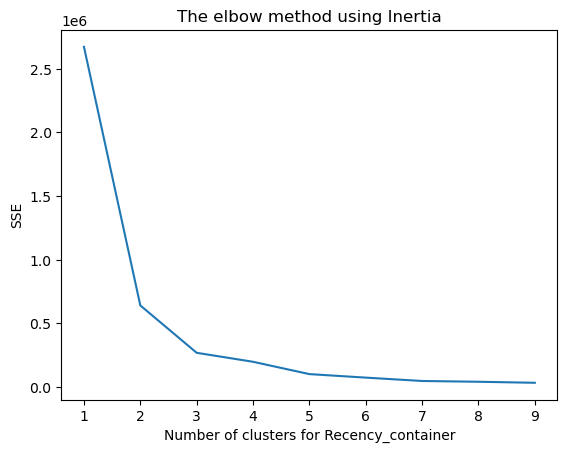

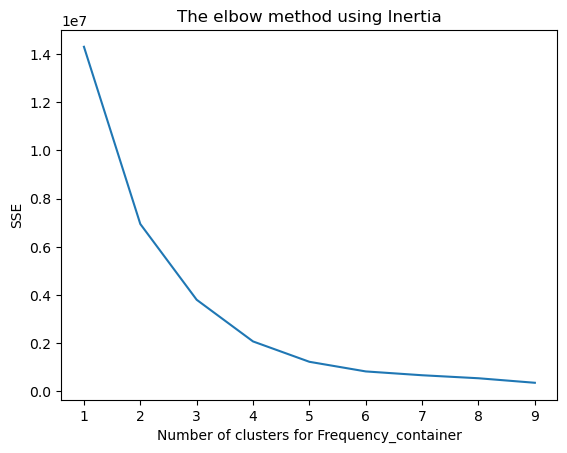

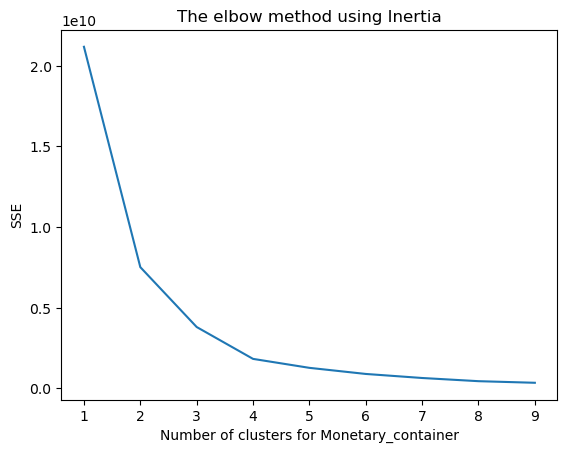

In [70]:

# sum of squared errors

for key,val in container_list.items():
    optimal_cluster_no(val) 
    
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel(f"Number of clusters for {key}")
    plt.ylabel("SSE")
    plt.title("The elbow method using Inertia")
    # plt.grid()
    plt.show()



Observation:
At 3, the elbow shows the change in the sum of squared error is minimal. The optimal cluster appears to be 3. We will be selecting 4 cluster according to this analysis to be more representative of business needs

In [71]:
#clustering with 4 optimal clusters 
def assign_clusters(df, container):
    for  key, val in container.items():
        kmeans =  KMeans(n_clusters=4, random_state=0, n_init= "auto")
        name  =  key.split('_', 1)[0] + "_Cluster"
        df[name] = kmeans.fit_predict(val)
    return df

In [72]:

        
segment_full_df = assign_clusters(segment_full_df, container_list)
segment_full_df

,CustomerID,Recency,Frequency,Monetary,Recency_Cluster,Frequency_Cluster,Monetary_Cluster
0,12347,20,42,1018.77,1,0,0
1,12348,85,5,367.00,0,0,0
2,12352,99,21,608.76,0,0,0
3,12353,41,4,89.00,1,0,0
4,12354,69,58,1079.40,2,0,0
...,...,...,...,...,...,...,...
2325,18273,94,1,51.00,0,0,0
2326,18280,114,10,180.60,0,0,0
2327,18281,17,7,80.82,3,0,0
2328,18283,6,211,524.68,3,2,0


In [73]:
last_6m_date =  pd.to_datetime('2011-07-01 00:00:00')
last_6m = df[df['InvoiceDate']> last_6m_date]
clv_last_6m = last_6m.groupby('CustomerID')['TotalSales'].sum().reset_index(name= 'LifetimeValue')
clv_last_6m

,CustomerID,LifetimeValue
0,12347,2104.05
1,12348,310.00
2,12349,1457.55
3,12352,944.23
4,12356,58.35
...,...,...
3350,18277,110.38
3351,18278,173.90
3352,18282,178.05
3353,18283,1252.30


In [74]:
last_6m

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSales,YearQuarter
245903,558638,84836,12,2011-07-01 08:16:00,1.25,16317,United Kingdom,15.00,2011Q3
245904,558638,71459,24,2011-07-01 08:16:00,0.85,16317,United Kingdom,20.40,2011Q3
245905,558638,22784,3,2011-07-01 08:16:00,4.95,16317,United Kingdom,14.85,2011Q3
245906,558638,23145,12,2011-07-01 08:16:00,0.95,16317,United Kingdom,11.40,2011Q3
245907,558638,22674,12,2011-07-01 08:16:00,1.25,16317,United Kingdom,15.00,2011Q3
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,12,2011-12-09 12:50:00,0.85,12680,France,10.20,2011Q4
541905,581587,22899,6,2011-12-09 12:50:00,2.10,12680,France,12.60,2011Q4
541906,581587,23254,4,2011-12-09 12:50:00,4.15,12680,France,16.60,2011Q4
541907,581587,23255,4,2011-12-09 12:50:00,4.15,12680,France,16.60,2011Q4


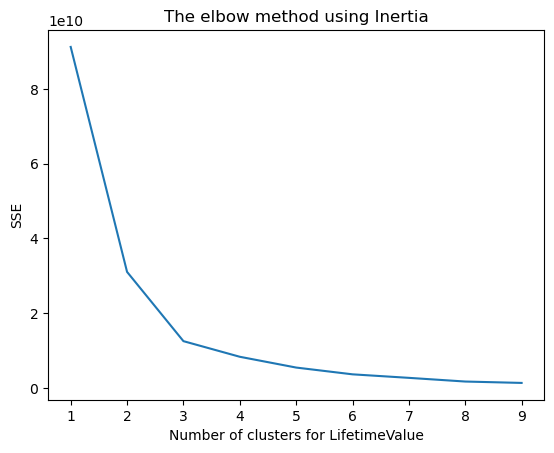

In [75]:
sse_2 = {}


for k in range(1,10):
    kmeans =    KMeans(n_clusters=k, random_state=0, n_init="auto")
    kmeans.fit(clv_last_6m[['LifetimeValue']])
    sse_2[k] = kmeans.inertia_



plt.figure()
plt.plot(list(sse_2.keys()), list(sse_2.values()))
plt.xlabel(f"Number of clusters for LifetimeValue")
plt.ylabel("SSE")
plt.title("The elbow method using Inertia")
# plt.grid()
plt.show()

# Lifetime value cluster for the last 6 months shows an optimal number of 3 clusters

In [76]:
kmeans =  KMeans(n_clusters=4, random_state=0, n_init= "auto")
clv_last_6m['LifetimeValue_Cluster'] = kmeans.fit_predict(clv_last_6m[['LifetimeValue']])

In [77]:
clv_last_6m.groupby('LifetimeValue_Cluster')['LifetimeValue'].describe()

,count,mean,std,min,25%,50%,75%,max
LifetimeValue_Cluster,,,,,,,,
0,3099.0,724.430346,627.702145,6.20,259.6400,505.480,1009.4300,2919.81
1,4.0,122937.757500,26192.883568,94947.08,105005.3075,121874.100,139806.5500,153055.75
2,22.0,30921.279545,12783.513185,18053.20,21555.5225,26143.995,35092.2825,63311.41
3,230.0,5151.517348,2663.416071,2924.87,3477.7500,4141.515,5651.2950,16074.50


In [78]:
#Lifetime vale is same ase revenue which is the Monetary which has been aggregrated for each customer in the last 6 months of the cycle
segment_full_df = segment_full_df.merge(clv_last_6m, how='left', on = ['CustomerID'])
segment_full_df = segment_full_df.fillna(0)
segment_full_df

,CustomerID,Recency,Frequency,Monetary,Recency_Cluster,Frequency_Cluster,Monetary_Cluster,LifetimeValue,LifetimeValue_Cluster
0,12347,20,42,1018.77,1,0,0,2104.05,0.0
1,12348,85,5,367.00,0,0,0,310.00,0.0
2,12352,99,21,608.76,0,0,0,944.23,0.0
3,12353,41,4,89.00,1,0,0,0.00,0.0
4,12354,69,58,1079.40,2,0,0,0.00,0.0
...,...,...,...,...,...,...,...,...,...
2325,18273,94,1,51.00,0,0,0,153.00,0.0
2326,18280,114,10,180.60,0,0,0,0.00,0.0
2327,18281,17,7,80.82,3,0,0,0.00,0.0
2328,18283,6,211,524.68,3,2,0,1252.30,0.0


In [79]:
segment_full_df.groupby('Recency_Cluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
Recency_Cluster,,,,,,,,
0,557.0,95.788151,13.183064,76.0,84.0,94.0,106.0,120.0
1,621.0,29.843800,7.574772,20.0,22.0,29.0,37.0,42.0
2,499.0,55.949900,9.662762,43.0,48.0,54.0,63.0,75.0
3,653.0,9.212864,5.441464,0.0,5.0,9.0,14.0,19.0


Observation:
 it appears that the cluster size is not represaentative of the mean recency in terms of ordinal encoding or ordinal values, in the description above,  	Customers with recency means around 153.350674 was clustered as 1 while Customers with recency means around 69.211079 were clustered as 0. The next code chunk will aim to categorise clusters ordinally.

In [80]:
segment_full_df.groupby('Recency_Cluster')['Recency'].mean().reset_index(name = "Recency_mean")


,Recency_Cluster,Recency_mean
0,0,95.788151
1,1,29.843800
2,2,55.949900
3,3,9.212864


In [81]:
#Ordering clusters ordinally categories
def order_clusters(cluster_name, target_name, df, ascending):
    df_new =  df.groupby(cluster_name)[target_name].mean().reset_index()
    
    df_new = df_new.sort_values(by=target_name, ascending = ascending).reset_index(drop =True)

    df_new["index"] =df_new.index #creating new index based on existing index ".index"

    df_final =  pd.merge(df, df_new[[cluster_name, "index"]], on= cluster_name) #we are merging two dataframe sna dropping one of the columns at the point of merging

    df_final.drop([cluster_name], axis=1, inplace=True) #dropping the old cluster
    df_final.rename(columns={"index": cluster_name}, inplace=True) #renaming index as the new cluster  

    return df_final


segment_full_df = order_clusters('Recency_Cluster', 'Recency', segment_full_df, False)
segment_full_df

,CustomerID,Recency,Frequency,Monetary,Frequency_Cluster,Monetary_Cluster,LifetimeValue,LifetimeValue_Cluster,Recency_Cluster
0,12347,20,42,1018.77,0,0,2104.05,0.0,2
1,12348,85,5,367.00,0,0,310.00,0.0,0
2,12352,99,21,608.76,0,0,944.23,0.0,0
3,12353,41,4,89.00,0,0,0.00,0.0,2
4,12354,69,58,1079.40,0,0,0.00,0.0,1
...,...,...,...,...,...,...,...,...,...
2325,18273,94,1,51.00,0,0,153.00,0.0,0
2326,18280,114,10,180.60,0,0,0.00,0.0,0
2327,18281,17,7,80.82,0,0,0.00,0.0,3
2328,18283,6,211,524.68,2,0,1252.30,0.0,3


In [82]:
segment_full_df.groupby('Recency_Cluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
Recency_Cluster,,,,,,,,
0,557.0,95.788151,13.183064,76.0,84.0,94.0,106.0,120.0
1,499.0,55.949900,9.662762,43.0,48.0,54.0,63.0,75.0
2,621.0,29.843800,7.574772,20.0,22.0,29.0,37.0,42.0
3,653.0,9.212864,5.441464,0.0,5.0,9.0,14.0,19.0


Now clusters are arranged according to the order of most recency duration of customers with customers having lesser time from when they last visited for a purchase ordered under cluster 3

In [83]:
segment_full_df.head()

,CustomerID,Recency,Frequency,Monetary,Frequency_Cluster,Monetary_Cluster,LifetimeValue,LifetimeValue_Cluster,Recency_Cluster
0,12347,20,42,1018.77,0,0,2104.05,0.0,2
1,12348,85,5,367.00,0,0,310.00,0.0,0
2,12352,99,21,608.76,0,0,944.23,0.0,0
3,12353,41,4,89.00,0,0,0.00,0.0,2
4,12354,69,58,1079.40,0,0,0.00,0.0,1


Action : 4 optimal clusters is chosen

In [84]:
segment_full_df.groupby('Frequency_Cluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
Frequency_Cluster,,,,,,,,
0,2032.0,26.779528,20.057981,1.0,11.0,21.0,39.0,81.0
1,13.0,596.846154,167.533502,377.0,501.0,568.0,627.0,886.0
2,283.0,136.240283,53.051884,82.0,95.0,123.0,154.5,355.0
3,2.0,1663.000000,352.139177,1414.0,1538.5,1663.0,1787.5,1912.0


Applying ordinal categorizing: such that highly frequent score is ordered as cluster 3 > cluster 2 > cluster 1> cluster 0

In [85]:
segment_full_df.groupby('Frequency_Cluster')['Frequency'].mean()

Frequency_Cluster
0      26.779528
1     596.846154
2     136.240283
3    1663.000000
Name: Frequency, dtype: float64

In [86]:
segment_full_df = order_clusters('Frequency_Cluster','Frequency', segment_full_df, True)
segment_full_df

,CustomerID,Recency,Frequency,Monetary,Monetary_Cluster,LifetimeValue,LifetimeValue_Cluster,Recency_Cluster,Frequency_Cluster
0,12347,20,42,1018.77,0,2104.05,0.0,2,0
1,12348,85,5,367.00,0,310.00,0.0,0,0
2,12352,99,21,608.76,0,944.23,0.0,0,0
3,12353,41,4,89.00,0,0.00,0.0,2,0
4,12354,69,58,1079.40,0,0.00,0.0,1,0
...,...,...,...,...,...,...,...,...,...
2325,18273,94,1,51.00,0,153.00,0.0,0,0
2326,18280,114,10,180.60,0,0.00,0.0,0,0
2327,18281,17,7,80.82,0,0.00,0.0,3,0
2328,18283,6,211,524.68,0,1252.30,0.0,3,1


In [87]:
segment_full_df.groupby('Frequency_Cluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
Frequency_Cluster,,,,,,,,
0,2032.0,26.779528,20.057981,1.0,11.0,21.0,39.0,81.0
1,283.0,136.240283,53.051884,82.0,95.0,123.0,154.5,355.0
2,13.0,596.846154,167.533502,377.0,501.0,568.0,627.0,886.0
3,2.0,1663.000000,352.139177,1414.0,1538.5,1663.0,1787.5,1912.0


In [88]:
segment_full_df.head()

,CustomerID,Recency,Frequency,Monetary,Monetary_Cluster,LifetimeValue,LifetimeValue_Cluster,Recency_Cluster,Frequency_Cluster
0,12347,20,42,1018.77,0,2104.05,0.0,2,0
1,12348,85,5,367.00,0,310.00,0.0,0,0
2,12352,99,21,608.76,0,944.23,0.0,0,0
3,12353,41,4,89.00,0,0.00,0.0,2,0
4,12354,69,58,1079.40,0,0.00,0.0,1,0


In [89]:
# checking summary of monetary  based on grouping by monetary clusters 
segment_full_df.groupby("Monetary_Cluster")['Monetary'].describe()


,count,mean,std,min,25%,50%,75%,max
Monetary_Cluster,,,,,,,,
0,2215.0,596.303982,526.697689,2.90,226.5300,397.400,809.9900,2641.53
1,12.0,21456.679167,7001.570105,13796.38,15704.0375,20348.755,25152.1325,35996.78
2,100.0,4706.975110,1993.927010,2665.63,3234.8475,3950.560,5544.1500,12150.84
3,3.0,65772.120000,11889.955698,52844.81,60538.1350,68231.460,72235.7750,76240.09


Ordinal encoding of the Monetary clusters, assigning higher cluster number to high revenue customers.

In [90]:
# calling the order_clusters function.
segment_full_df = order_clusters('Monetary_Cluster', 'Monetary', segment_full_df, True)
# segment_full_df = order_clusters('LifetimeValue_Cluster', 'LifetimeValue', segment_full_df, True) unordered lifetime clusters because of visible bias

segment_full_df.groupby('Monetary_Cluster')['Monetary'].describe() #checking to see ordering took place

,count,mean,std,min,25%,50%,75%,max
Monetary_Cluster,,,,,,,,
0,2215.0,596.303982,526.697689,2.90,226.5300,397.400,809.9900,2641.53
1,100.0,4706.975110,1993.927010,2665.63,3234.8475,3950.560,5544.1500,12150.84
2,12.0,21456.679167,7001.570105,13796.38,15704.0375,20348.755,25152.1325,35996.78
3,3.0,65772.120000,11889.955698,52844.81,60538.1350,68231.460,72235.7750,76240.09


In [91]:
segment_full_df.groupby('LifetimeValue_Cluster')['LifetimeValue'].describe()

,count,mean,std,min,25%,50%,75%,max
LifetimeValue_Cluster,,,,,,,,
0.0,2110.0,617.475228,703.675766,0.00,0.0000,373.96,977.660,2917.00
1.0,4.0,122937.757500,26192.883568,94947.08,105005.3075,121874.10,139806.550,153055.75
2.0,21.0,29851.588095,12048.119374,18053.20,21312.1900,25994.88,35057.700,63311.41
3.0,195.0,5181.336821,2689.794441,2924.87,3423.2300,4126.36,5815.135,16074.50


In [128]:
segment_full_df= order_clusters('LifetimeValue_Cluster', 'LifetimeValue', segment_full_df, True)


In [129]:
segment_full_df.groupby('LifetimeValue_Cluster')['LifetimeValue'].describe()

,count,mean,std,min,25%,50%,75%,max
LifetimeValue_Cluster,,,,,,,,
0,2110.0,617.475228,703.675766,0.00,0.0000,373.96,977.660,2917.00
1,195.0,5181.336821,2689.794441,2924.87,3423.2300,4126.36,5815.135,16074.50
2,21.0,29851.588095,12048.119374,18053.20,21312.1900,25994.88,35057.700,63311.41
3,4.0,122937.757500,26192.883568,94947.08,105005.3075,121874.10,139806.550,153055.75


In [92]:
segment_full_df.head()

,CustomerID,Recency,Frequency,Monetary,LifetimeValue,LifetimeValue_Cluster,Recency_Cluster,Frequency_Cluster,Monetary_Cluster
0,12347,20,42,1018.77,2104.05,0.0,2,0,0
1,12348,85,5,367.00,310.00,0.0,0,0,0
2,12352,99,21,608.76,944.23,0.0,0,0,0
3,12353,41,4,89.00,0.00,0.0,2,0,0
4,12354,69,58,1079.40,0.00,0.0,1,0,0


Action: Obtaining OverallScore, based on ordinal categorizing, customer with the best RFM score will have a total score of 9. best recency score = 3, best frequency score  =  3 & best monetary score  =  3 and worst over all score will be 0

In [93]:
# first of all changing the data type of the clusters from object data type to integer to enable addition.
segment_full_df.dtypes

CustomerID                object
Recency                    int64
Frequency                  int64
Monetary                 float64
LifetimeValue            float64
LifetimeValue_Cluster    float64
Recency_Cluster            int64
Frequency_Cluster          int64
Monetary_Cluster           int64
dtype: object

In [94]:
segment_full_df['OverallScore'] = segment_full_df[['Recency_Cluster', 'Frequency_Cluster', 'Monetary_Cluster']].sum(axis=1)
segment_full_df.head()


,CustomerID,Recency,Frequency,Monetary,LifetimeValue,LifetimeValue_Cluster,Recency_Cluster,Frequency_Cluster,Monetary_Cluster,OverallScore
0,12347,20,42,1018.77,2104.05,0.0,2,0,0,2
1,12348,85,5,367.00,310.00,0.0,0,0,0,0
2,12352,99,21,608.76,944.23,0.0,0,0,0,0
3,12353,41,4,89.00,0.00,0.0,2,0,0,2
4,12354,69,58,1079.40,0.00,0.0,1,0,0,1


In [95]:
#Obtain top 20 customers based Overall score 
top20_Customers = segment_full_df.sort_values(by=['OverallScore'], ascending =False).head(15)

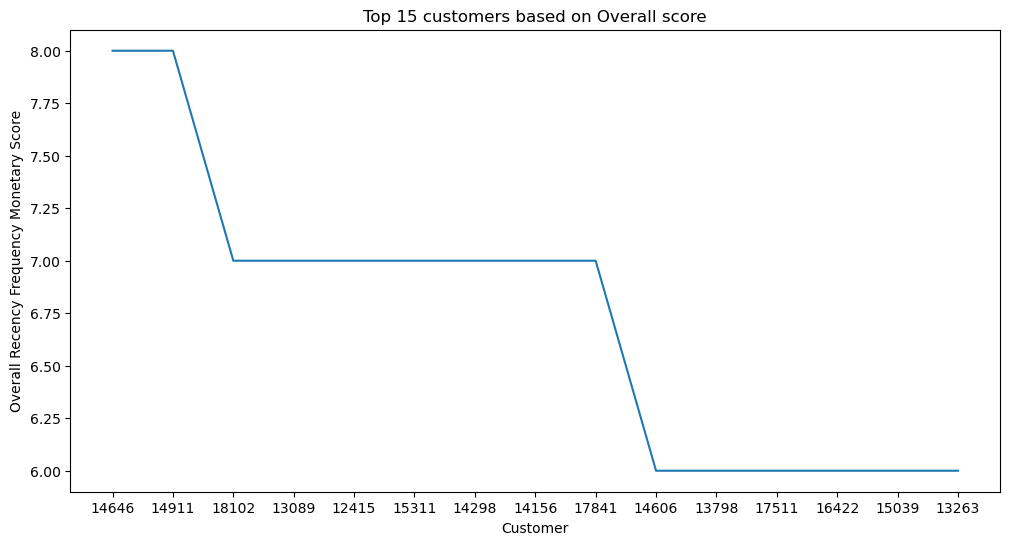

In [96]:
#Visualizing top customers based on Overall score 
plt.figure(figsize=(12,6))
sns.lineplot(top20_Customers, x = "CustomerID", y = "OverallScore")
plt.xlabel("Customer")
plt.ylabel("Overall Recency Frequency Monetary Score")
plt.title("Top 15 customers based on Overall score")
plt.show()

In [97]:
segment_full_df.shape

(2330, 10)

In [98]:
segment_full_df[segment_full_df['OverallScore']==5].count()

CustomerID               44
Recency                  44
Frequency                44
Monetary                 44
LifetimeValue            44
LifetimeValue_Cluster    44
Recency_Cluster          44
Frequency_Cluster        44
Monetary_Cluster         44
OverallScore             44
dtype: int64

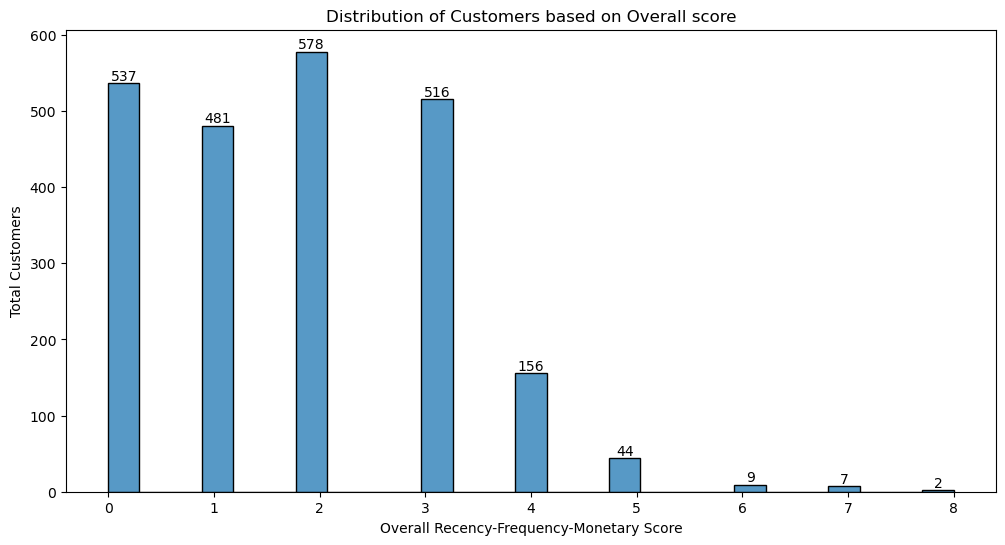

In [99]:
customer_distribtn = segment_full_df.sort_values(by=['OverallScore'], ascending =False)
#Visualizing top customers based on Overall score 
plt.figure(figsize=(12,6))
ax = sns.histplot(customer_distribtn, x = "OverallScore")

# Add value labels on top of bars
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Avoid labeling empty bins
        ax.annotate(f'{int(height)}', 
                    (p.get_x() + p.get_width() / 2, height), 
                    ha='center', va='bottom', fontsize=10, color='black')
        
plt.xlabel("Overall Recency-Frequency-Monetary Score")
plt.ylabel("Total Customers")
plt.title("Distribution of Customers based on Overall score")
plt.show()

In [100]:
segment_full_df.head()

,CustomerID,Recency,Frequency,Monetary,LifetimeValue,LifetimeValue_Cluster,Recency_Cluster,Frequency_Cluster,Monetary_Cluster,OverallScore
0,12347,20,42,1018.77,2104.05,0.0,2,0,0,2
1,12348,85,5,367.00,310.00,0.0,0,0,0,0
2,12352,99,21,608.76,944.23,0.0,0,0,0,0
3,12353,41,4,89.00,0.00,0.0,2,0,0,2
4,12354,69,58,1079.40,0.00,0.0,1,0,0,1


## Customer LifeTime Value (CLTV) - last 6 months  - Target value for prediction

Steps to Compute CLV:

CLV = Monetary value in the last 6 months of each customer because it has been grouped by total sales sum initially.

In [101]:
segment_full_df.head()

,CustomerID,Recency,Frequency,Monetary,LifetimeValue,LifetimeValue_Cluster,Recency_Cluster,Frequency_Cluster,Monetary_Cluster,OverallScore
0,12347,20,42,1018.77,2104.05,0.0,2,0,0,2
1,12348,85,5,367.00,310.00,0.0,0,0,0,0
2,12352,99,21,608.76,944.23,0.0,0,0,0,0
3,12353,41,4,89.00,0.00,0.0,2,0,0,2
4,12354,69,58,1079.40,0.00,0.0,1,0,0,1


In [102]:
df.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSales,YearQuarter
0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010Q4
1,536365,71053,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010Q4
2,536365,84406B,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010Q4
3,536365,84029G,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010Q4
4,536365,84029E,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010Q4


Observation:
4 optimal clusters were observed in the elbow method.

Observation: Observed that the lfietime is  ordinally categorized in the clustering. the longest lifetime value is clustered as lifetime cluster 3 > cluster2 > and so on

In [103]:

# Plot of LTV Histogram

plot_data = [go.Histogram(x=segment_full_df['LifetimeValue'])]

plot_layout = go.Layout(title='Revenue in last 6 months window')

fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [104]:
segment_full_df[segment_full_df['OverallScore'] == 8]

,CustomerID,Recency,Frequency,Monetary,LifetimeValue,LifetimeValue_Cluster,Recency_Cluster,Frequency_Cluster,Monetary_Cluster,OverallScore
913,14646,1,568,76240.09,135390.15,1.0,3,2,3,8
1018,14911,0,1414,30408.68,94947.08,1.0,3,3,2,8


In [105]:
# creating segment of the clusters 0 - Very Low CLV, clusters 1 - Low CLV, clusters 2 - Medium CLV, clusters 3 -  High CLV.Based on my human judgement for multiclass supervised learning
#  we know 8 is our best customer

segment_full_df['Segment'] = 'Very-Low-Value'

segment_full_df.loc[segment_full_df['OverallScore'] > 2, 'Segment'] = 'Low-Value'
segment_full_df.loc[segment_full_df['OverallScore'] > 4, 'Segment'] = 'Medium-Value'
segment_full_df.loc[segment_full_df['OverallScore'] > 6, 'Segment'] = 'High-Value'

In [106]:
segment_full_df.head()

,CustomerID,Recency,Frequency,Monetary,LifetimeValue,LifetimeValue_Cluster,Recency_Cluster,Frequency_Cluster,Monetary_Cluster,OverallScore,Segment
0,12347,20,42,1018.77,2104.05,0.0,2,0,0,2,Very-Low-Value
1,12348,85,5,367.00,310.00,0.0,0,0,0,0,Very-Low-Value
2,12352,99,21,608.76,944.23,0.0,0,0,0,0,Very-Low-Value
3,12353,41,4,89.00,0.00,0.0,2,0,0,2,Very-Low-Value
4,12354,69,58,1079.40,0.00,0.0,1,0,0,1,Very-Low-Value


In [107]:
# Scatter plot of LTV with plotly

segment_full_graph = segment_full_df.query("LifetimeValue < 40000") # because maximum values end at 40000 as seen in the histogram.

plot_data = [ go.Scatter( x=segment_full_graph.query("Segment == 'Very-Low-Value'")['OverallScore'],
                          y=segment_full_graph.query("Segment == 'Very-Low-Value'")['LifetimeValue'],
                          mode = 'markers',
                          name = 'Very Low',
                          marker= dict(size= 5, line= dict(width=1), color= 'blue', opacity= 0.8)
                          
                         ),
              go.Scatter( x=segment_full_graph.query("Segment == 'Low-Value'")['OverallScore'],
                          y=segment_full_graph.query("Segment == 'Low-Value'")['LifetimeValue'],
                          mode = 'markers',
                          name = 'Low',
                          marker= dict(size= 7, line= dict(width=1), color= 'yellow', opacity= 0.6)
                        ),
              go.Scatter( x=segment_full_graph.query("Segment == 'Medium-Value'")['OverallScore'],
                          y=segment_full_graph.query("Segment == 'Medium-Value'")['LifetimeValue'],
                          mode = 'markers',
                          name = 'Medium',
                          marker= dict(size= 9, line= dict(width=1), color= 'green', opacity= 0.8)
                        ),
              go.Scatter( x=segment_full_graph.query("Segment == 'High-Value'")['OverallScore'],
                          y=segment_full_graph.query("Segment == 'High-Value'")['LifetimeValue'],
                          mode = 'markers',
                          name = 'High',
                          marker= dict(size= 11, line= dict(width=1), color= 'red', opacity= 0.9)
                        )
                         ]



plot_layout = go.Layout(yaxis= {'title' : "LifeTime Value in 6 months window"}, 
                        xaxis = {'title' : "RFM Score"},
                        title =  'LTV')

fig = go.Figure(data=plot_data, layout = plot_layout)

pyoff.iplot(fig) #iplot polots in a jupyter notebook or python kernel

Postive correleation observed between the RFM Score and the LTV 

Action: Obtaining OverallScore, based on ordinal categorizing, customer with the best RFM score will have a total score of 9. best recency score = 3, best frequency score  =  3 & best monetary score  =  3 and worst over all score will be 0

Observation:
We have completed the engineering of features. In this study, CLTV method, we have used clustering “https://blueorange.digital/blog/3-best-machine-learning-models-to-predict-customer-lifetime-value-cltv/” as a preliminary step before training the machine learning model.
Each of these clusters can be assigned a label, in which in our own case, we have assigned the RFM to an overall score label

if we create labels based on LifetimeValue_clusters making clusters 0 - Very Low CLV, clusters 1 - Low CLV, clusters 2 - Medium CLV, clusters 3 -  High CLV. Then we have turned our machine learning problem to a supervised learning and a multi-class classification problem. Random forest which combines multiple decision trees, are useful in multi-class classification, because they are not sensitive to missing values (we have some missing values of revenue in the last 6 months due to churn), and random forest can handle non-linear features such as the cluster features engineered in this dataset.

A regression model such as XGboost can be used based on it track record of predicting continuous variables by starting with weak learners and combining results of prediction from the weak learners to cancel out erroneaus predictions, it a robust ensemble learning algorithm.
Neural networks can also be used to capture the intricate patterns for a supervised regression task.

The statistical models could also be used as a base line for prediction of future transactions, monetary value of transactions, and prediction of CLTV values itself not clusters. The advantage of  Random forest, XGboost, and ANN (deep learning) is their ability to employ non-linear features in discovering intricate patterns and making accurate prediction as compared to Beta-Geometric/Negative Binomial Distribution statistical methods which will require linear relationships between (predictors and dependent variables).

Observation:
-if i use the first 18 months (Jan 2010 – June 2011) as training data to model customer behavior.
Then, you  validate predictions on the last 6 months (July 2011 – Dec 2011).
The data set will be biased and data leakage, because it has labelled churned as customers churned in the last 6 months, so i will have to move my 6 months backward to from the first quarter of 2011 to 2nd quarter of 2011. this is the first 6 months in 2011 or use the whole year of 2011 as customers churned in the last 1 year.
so my training data will be from 2010, to 2nd quarter of 2011. and test/validation data will be from last 6 months in 2011.
A 6-month churn window is a common industry standard for retail and e-commerce, as it accounts for seasonal trends and purchase cycles.


if i create a recency and frequency and monetary value from a cut off data july 2011. Then 

Steps:
1. We'd start with predicting future transactions, monetary value of transactions, and prediction of CLTV values using Beta-Geometric/Negative Binomial Distribution, Gamma-Gamma statistical methods.
2. Then multiclass- classification with Random Forest to predict customer lifetime value for 

- first we will drop the monetary values and the lifetime values and its clusters possibliy because that is our target, then other features will be the used as predictors/independent variables.
-  cluster lifetime values
- then we can now do a multiclass classification with 

# Machine Learning Model for CLV prediction

In [108]:
segment_full_df.head()

,CustomerID,Recency,Frequency,Monetary,LifetimeValue,LifetimeValue_Cluster,Recency_Cluster,Frequency_Cluster,Monetary_Cluster,OverallScore,Segment
0,12347,20,42,1018.77,2104.05,0.0,2,0,0,2,Very-Low-Value
1,12348,85,5,367.00,310.00,0.0,0,0,0,0,Very-Low-Value
2,12352,99,21,608.76,944.23,0.0,0,0,0,0,Very-Low-Value
3,12353,41,4,89.00,0.00,0.0,2,0,0,2,Very-Low-Value
4,12354,69,58,1079.40,0.00,0.0,1,0,0,1,Very-Low-Value


In [109]:
#converting categorical columns to numerical
segment_full_cluster = segment_full_df.copy()
dummies = pd.get_dummies(segment_full_cluster['Segment'], prefix= "Segment", dtype=int)
segment_full_class = pd.concat([segment_full_cluster, dummies], axis =1)
segment_full_class.drop(['Segment'], axis =1, inplace =True)

segment_full_class.head()

,CustomerID,Recency,Frequency,Monetary,LifetimeValue,LifetimeValue_Cluster,Recency_Cluster,Frequency_Cluster,Monetary_Cluster,OverallScore,Segment_High-Value,Segment_Low-Value,Segment_Medium-Value,Segment_Very-Low-Value
0,12347,20,42,1018.77,2104.05,0.0,2,0,0,2,0,0,0,1
1,12348,85,5,367.00,310.00,0.0,0,0,0,0,0,0,0,1
2,12352,99,21,608.76,944.23,0.0,0,0,0,0,0,0,0,1
3,12353,41,4,89.00,0.00,0.0,2,0,0,2,0,0,0,1
4,12354,69,58,1079.40,0.00,0.0,1,0,0,1,0,0,0,1


In [110]:
# Repostioning te lifetime value to reflect as target at the end.
columns =  [col for col in segment_full_class.columns if col != 'LifetimeValue_Cluster'] + ['LifetimeValue_Cluster']
segment_full_class = segment_full_class[columns]
segment_full_class['CustomerID'] = segment_full_class['CustomerID'].astype('int')
segment_full_class.head()



,CustomerID,Recency,Frequency,Monetary,LifetimeValue,Recency_Cluster,Frequency_Cluster,Monetary_Cluster,OverallScore,Segment_High-Value,Segment_Low-Value,Segment_Medium-Value,Segment_Very-Low-Value,LifetimeValue_Cluster
0,12347,20,42,1018.77,2104.05,2,0,0,2,0,0,0,1,0.0
1,12348,85,5,367.00,310.00,0,0,0,0,0,0,0,1,0.0
2,12352,99,21,608.76,944.23,0,0,0,0,0,0,0,1,0.0
3,12353,41,4,89.00,0.00,2,0,0,2,0,0,0,1,0.0
4,12354,69,58,1079.40,0.00,1,0,0,1,0,0,0,1,0.0


In [111]:
# X  and y Train sets
X = segment_full_class.drop(['CustomerID',  'OverallScore', 'Monetary_Cluster','Recency_Cluster',	'Frequency_Cluster', 'LifetimeValue',  'LifetimeValue_Cluster',  'Segment_High-Value', 'Segment_Low-Value', 'Segment_Medium-Value', 'Segment_Very-Low-Value'], axis =1)
y= segment_full_class['LifetimeValue_Cluster']


In [112]:
X

,Recency,Frequency,Monetary
0,20,42,1018.77
1,85,5,367.00
2,99,21,608.76
3,41,4,89.00
4,69,58,1079.40
...,...,...,...
2325,94,1,51.00
2326,114,10,180.60
2327,17,7,80.82
2328,6,211,524.68


In [113]:
y

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
2325    0.0
2326    0.0
2327    0.0
2328    0.0
2329    0.0
Name: LifetimeValue_Cluster, Length: 2330, dtype: float64

In [114]:
y.value_counts(normalize=True)


LifetimeValue_Cluster
0.0    0.905579
3.0    0.083691
2.0    0.009013
1.0    0.001717
Name: proportion, dtype: float64

In [115]:
#Random forest multi class classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
# from sklearn.externals import joblib


# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=42)

classifier = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=42)

rf_model =classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print(f'Accuracy of random forest on training set: {rf_model.score(X_train, y_train)}')
print(f'Accuracy of random forest on test set: {rf_model.score(X_test[X_train.columns], y_test):.3f}')

Accuracy of random forest on training set: 1.0
Accuracy of random forest on test set: 0.922


In [116]:
#split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=56)

In [117]:
import xgboost as xgb

#XGBoost Multiclassification Model
ltv_xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, n_jobs=-1).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb_model.score(X_test[X_train.columns], y_test)))

y_pred = ltv_xgb_model.predict(X_test)

Accuracy of XGB classifier on training set: 0.97
Accuracy of XGB classifier on test set: 0.90


In [118]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.90      0.99      0.94       102
         2.0       1.00      1.00      1.00         1
         3.0       0.75      0.21      0.33        14

    accuracy                           0.90       117
   macro avg       0.88      0.73      0.76       117
weighted avg       0.88      0.90      0.87       117



the overfitting can be mostly explained by the class imbalance of the target variable lifetime cluster.

In [119]:
# Get feature importances as a numpy array
importances = ltv_xgb_model.feature_importances_
print(importances)

[0.14179277 0.12538609 0.73282117]


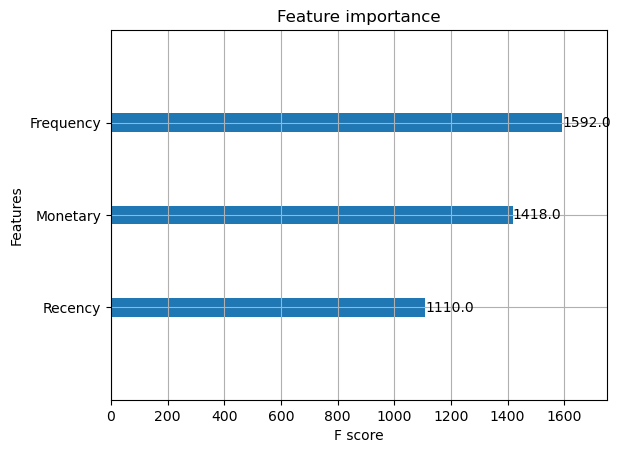

In [120]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(ltv_xgb_model)
plt.show()

In [127]:
# Obtaining important versions for visualization
print("numpy==", np.__version__)
print("pandas==", pd.__version__)
print("scikit-learn==", sklearn.__version__)
print("xgboost ==",xgb.__version__ )



numpy== 1.26.4
pandas== 2.2.3
scikit-learn== 1.6.1
xgboost == 2.1.4


In [122]:
import joblib # or use pickle

#after model training
model = ltv_xgb_model

#saving model using joblib
joblib.dump(model, 'clv_churn_model.pkl')



['clv_churn_model.pkl']

In [123]:
#saving model because its an xgboost model saved as .bst
model.save_model('clv_churn_model.bst')


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[20:14:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1738880294500/work/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.

